In [1]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers, optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix
import os
import statistics
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)

Using TensorFlow backend.


In [2]:
benign_path = '/home/sdsra/Downloads/CTU-Dataset/benign'
benign_datas = pd.DataFrame()
sub_dir_list = os.listdir(benign_path)
for dir in sub_dir_list:
    tmp_data = pd.read_pickle(benign_path + '/' + dir + '/datas-by-origin-tool.pkl')
    benign_datas = pd.concat([benign_datas, tmp_data], ignore_index=True)

In [3]:
malware_path = '/home/sdsra/Downloads/CTU-Dataset/malware-2' 
malware_datas = pd.DataFrame()
for dir in os.listdir(malware_path) :
    pkl_path = malware_path +'/'+dir+'/datas-by-origin-tool.pkl'
    if os.path.exists(pkl_path):
        tmp_data = pd.read_pickle(pkl_path)
        malware_datas = pd.concat([malware_datas, tmp_data], ignore_index=True)

In [4]:
benign_datas['label'].value_counts()

benign    12971
Name: label, dtype: int64

In [5]:
benign_datas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12971 entries, 0 to 12970
Data columns (total 33 columns):
amount_diff_cert                12971 non-null int64
avg_of_cert_length              12971 non-null float64
avg_of_duration                 12971 non-null float64
avg_of_public_key               12971 non-null float64
avg_periodicity                 12971 non-null float64
dst_ip                          12971 non-null object
dst_port                        12971 non-null object
get_SNI_equal_Dst_IP            12971 non-null int64
inbound_pckts                   12971 non-null int64
is_CNs_in_SNA_dns               12971 non-null int64
is_SNIs_in_SNA_dns              12971 non-null int64
is_valid_cert                   12971 non-null int64
number_of_cert_path             12971 non-null float64
number_of_domains               12971 non-null float64
number_of_flows                 12971 non-null int64
outbound_pckts                  12971 non-null int64
percent_of_established_stats 

In [6]:
malware_datas['label'].value_counts()

botnet    71409
benign        3
Name: label, dtype: int64

In [7]:
malware_datas = malware_datas[malware_datas['label'] == 'botnet']

In [8]:
len(malware_datas)

71409

In [9]:
numeric_columns = list(filter(lambda x: x not in ['src_ip','src_port','dst_ip','dst_port','proto', 'label'], benign_datas.columns))

# Data preprocessing 

In [10]:
X_train, X_test = train_test_split(benign_datas, test_size=0.2, random_state = 101)

In [11]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_test_scaled  = scaler.transform(X_test[numeric_columns])

/home/sdsra/anaconda3/envs/gep-gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [12]:
# autoencoder 1(6 hidden, tanh)
# input_layer = Input(shape=(28,))
# encoder = Dense(20, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
# encoder = Dense(14, activation='tanh')(encoder)
# encoder = Dense(8, activation='tanh')(encoder)
# decoder = Dense(14, activation='tanh')(encoder)
# decoder = Dense(20, activation='tanh')(decoder)
# decoder = Dense(28, activation='tanh')(decoder)

# autoencoder 2(4 hidden, relu)
# input_layer = Input(shape=(28,))
# encoder = Dense(20, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
# encoder = Dense(14, activation='relu')(encoder)
# decoder = Dense(20, activation='relu')(encoder)
# decoder = Dense(28, activation='sigmoid')(decoder)



# autoencoder 3(10 hidden, relu)
input_layer = Input(shape=(28,))
encoder = Dense(23, activation='relu')(input_layer)
encoder = Dense(18, activation='relu')(encoder)
encoder = Dense(15, activation='relu')(encoder)
encoder = Dense(10, activation='relu')(encoder)
encoder = Dense(6, activation='relu')(encoder)
decoder = Dense(10, activation='relu')(encoder)
decoder = Dense(15, activation='relu')(decoder)
decoder = Dense(18, activation='relu')(decoder)
decoder = Dense(23, activation='relu')(decoder)
decoder = Dense(28, activation='sigmoid')(decoder)







autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 23)                667       
_________________________________________________________________
dense_2 (Dense)              (None, 18)                432       
_________________________________________________________________
dense_3 (Dense)              (None, 15)                285       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 66        
_________________________________________________________________
dense_6 (Dense)              (None, 10)                70        
__________

In [13]:
nb_epoch = 100
batch_size = 50
adam = optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(optimizer=adam, loss='mse')

history = autoencoder.fit(X_train_scaled, X_train_scaled,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.1
                        )
autoencoder.save_weights('./ae_weights.h5')

Train on 9338 samples, validate on 1038 samples
Epoch 1/100
9338/9338 [==============================] - 2s 248us/step - loss: 0.0371 - val_loss: 0.0069
Epoch 2/100
9338/9338 [==============================] - 1s 129us/step - loss: 0.0056 - val_loss: 0.0038
Epoch 3/100
9338/9338 [==============================] - 2s 163us/step - loss: 0.0037 - val_loss: 0.0030
Epoch 4/100
9338/9338 [==============================] - 1s 151us/step - loss: 0.0032 - val_loss: 0.0027
Epoch 5/100
9338/9338 [==============================] - 1s 155us/step - loss: 0.0030 - val_loss: 0.0027
Epoch 6/100
9338/9338 [==============================] - 2s 165us/step - loss: 0.0029 - val_loss: 0.0026
Epoch 7/100
9338/9338 [==============================] - 2s 214us/step - loss: 0.0029 - val_loss: 0.0025
Epoch 8/100
9338/9338 [==============================] - 1s 117us/step - loss: 0.0028 - val_loss: 0.0024
Epoch 9/100
9338/9338 [==============================] - 1s 155us/step - loss: 0.0028 - val_loss: 0.0024
Epoch 1

9338/9338 [==============================] - 2s 173us/step - loss: 8.5017e-04 - val_loss: 8.5637e-04
Epoch 78/100
9338/9338 [==============================] - 1s 134us/step - loss: 8.5616e-04 - val_loss: 8.4027e-04
Epoch 79/100
9338/9338 [==============================] - 2s 164us/step - loss: 8.5403e-04 - val_loss: 8.4370e-04
Epoch 80/100
9338/9338 [==============================] - 1s 115us/step - loss: 8.4525e-04 - val_loss: 8.4301e-04
Epoch 81/100
9338/9338 [==============================] - 1s 160us/step - loss: 8.4275e-04 - val_loss: 8.7450e-04
Epoch 82/100
9338/9338 [==============================] - 1s 158us/step - loss: 8.4253e-04 - val_loss: 8.4058e-04
Epoch 83/100
9338/9338 [==============================] - 1s 128us/step - loss: 8.3295e-04 - val_loss: 8.3947e-04
Epoch 84/100
9338/9338 [==============================] - 1s 131us/step - loss: 8.2429e-04 - val_loss: 8.2614e-04
Epoch 85/100
9338/9338 [==============================] - 1s 70us/step - loss: 8.1832e-04 - val_loss:

In [54]:
scaled_malware_datas = scaler.transform(malware_datas[numeric_columns])

In [23]:
new_encoder = Model(input = input_layer, output=encoder)

/home/sdsra/anaconda3/envs/gep-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [65]:
malware_pred = new_encoder.predict(scaled_malware_datas)

In [66]:
malware_datas['mse'] = np.mean(np.power(malware_pred, 2), axis=1)

In [67]:
y_pred = new_encoder.predict(X_test_scaled)

In [68]:
X_test['mse'] = np.mean(np.power(y_pred, 2), axis=1)

/home/sdsra/anaconda3/envs/gep-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [93]:
X_test['label'] = 'no'
X_test['is_malware'] = 0

/home/sdsra/anaconda3/envs/gep-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/sdsra/anaconda3/envs/gep-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [94]:
malware_datas['label'] = 'yes'
malware_datas['is_malware'] = 1

In [95]:
compare_data = pd.concat([malware_datas, X_test], ignore_index=True)

In [97]:
compare_data['label'].value_counts()

yes    71409
no      2595
Name: label, dtype: int64

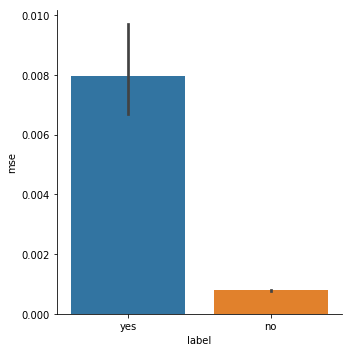

In [98]:
sns.catplot(x='label', y='mse', order=['yes','no'] ,data=compare_data, kind='bar')

In [90]:
threshold = 0.002

In [91]:
data_predict = compare_data.apply(lambda x: 1 if x['mse'] > threshold else 0, axis=1)

In [99]:
data_real = compare_data['is_malware']

In [100]:
confusion_matrix(data_real, data_predict)

array([[ 2588,     7],
       [65839,  5570]])